# **Flower Recognition**

<center><img src="https://storage.googleapis.com/kaggle-datasets-images/8782/12270/c3af536d14e386a2bfd356d1cd84b67e/dataset-cover.jpg?t=2018-01-06-14-10-54"></center>

This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.


## Setup

In [ ]:
from google.colab import files
files.upload()  
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition -p /content/

 96% 433M/450M [00:03<00:00, 199MB/s]
100% 450M/450M [00:03<00:00, 130MB/s]


In [ ]:
!unzip -q /content/flowers-recognition.zip
!rm /content/flowers-recognition.zip

In [ ]:
! pip install timm albumentations==0.4.6

     |████████████████████████████████| 122kB 25.1MB/s 
     |████████████████████████████████| 952kB 42.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=70cd9910ef1a0067e4545de0c52d40bfcdd2fa6888aa0a6c5363a26278622296
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [124]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read dataset

In [65]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
import timm

In [55]:
import gc
def empty_cache():
    torch.cuda.empty_cache()
    gc.collect()

In [56]:
empty_cache()

In [7]:
DATA_DIR = "flowers/"
classes = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, 'tulip': 4}
labels_names = ['daisy','dandelion','rose','sunflower','tulip']
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

allFilenames = []
allCategories = []
for classElement in classes:
    filenames = os.listdir(DATA_DIR+classElement)
    filenames = list(filter(lambda x: is_image_file(x),filenames))
    allFilenames += [classElement + "/" + file for file in filenames]
    allCategories += [classes[classElement]] * len(filenames)


df = pd.DataFrame({
    'filename': allFilenames,
    'class': allCategories
})
df.head()

filename  class
0    daisy/100080576_f52e8ee070_n.jpg      0
1    daisy/10140303196_b88d3d6cec.jpg      0
2  daisy/10172379554_b296050f82_n.jpg      0
3    daisy/10172567486_2748826a8b.jpg      0
4  daisy/10172636503_21bededa75_n.jpg      0

In [8]:
# function to display multiple images

def display_multiple_img(images_paths, rows, cols,title):
    
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8))
    plt.suptitle(title, fontsize=20)
    for ind,image_path in enumerate(images_paths):
        image = cv2.imread(DATA_DIR + image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Distribution of classes')

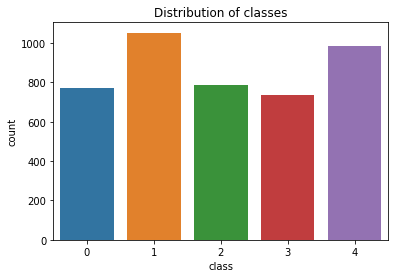

In [9]:
sns.countplot(x="class", data=df)
plt.title("Distribution of classes")

0 daisy


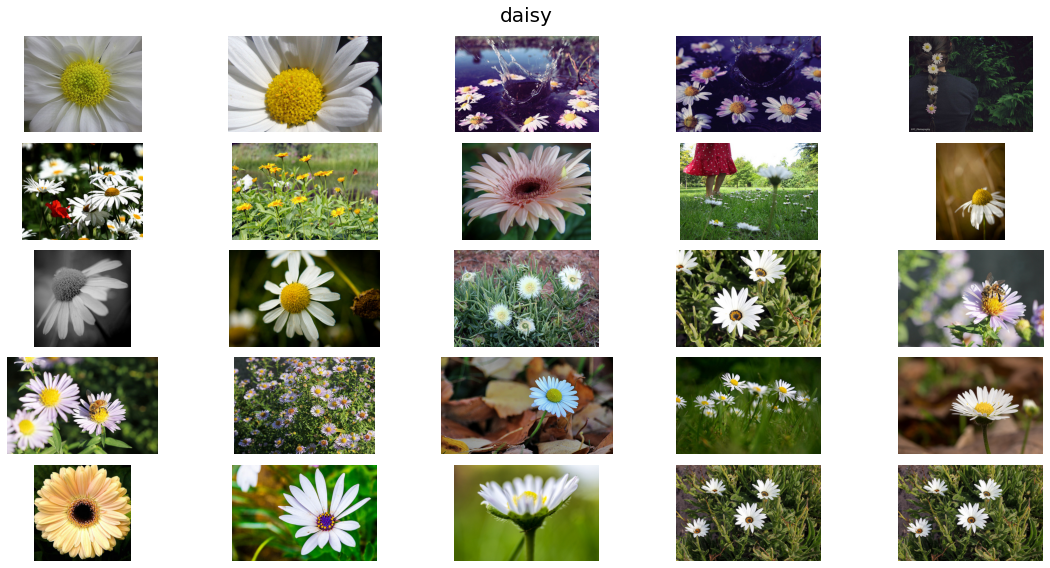

1 dandelion


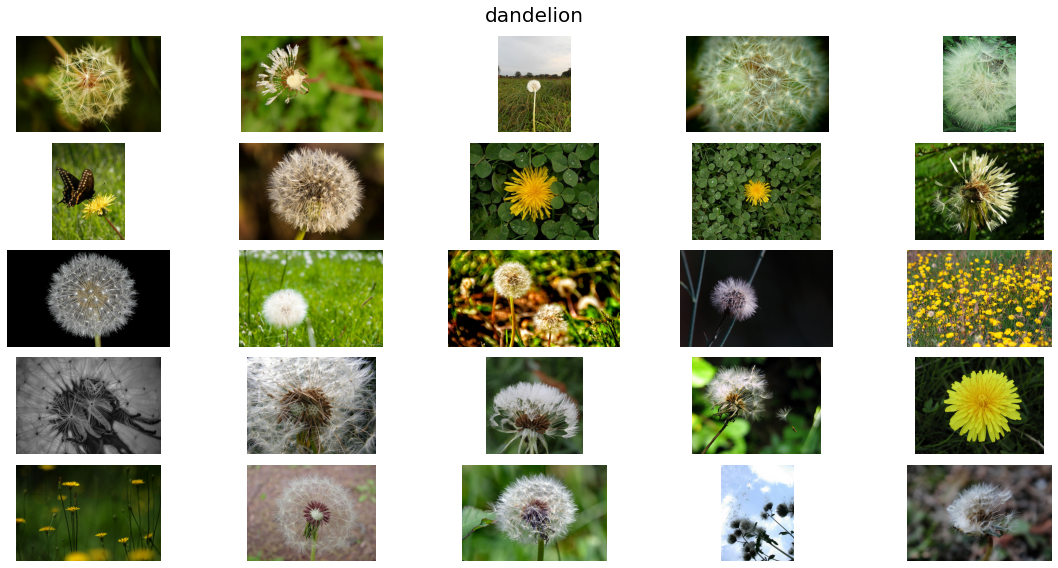

2 rose


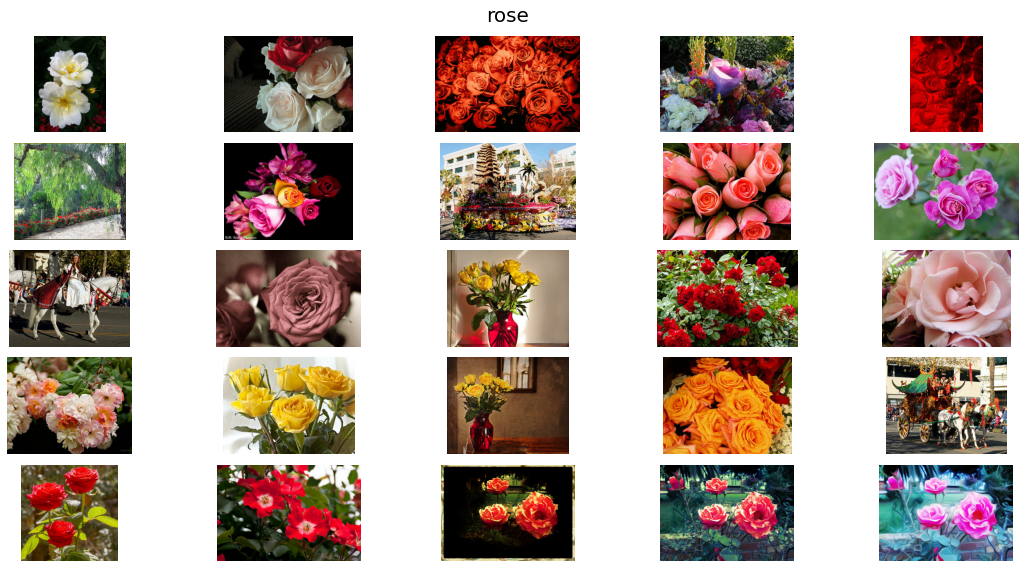

3 sunflower


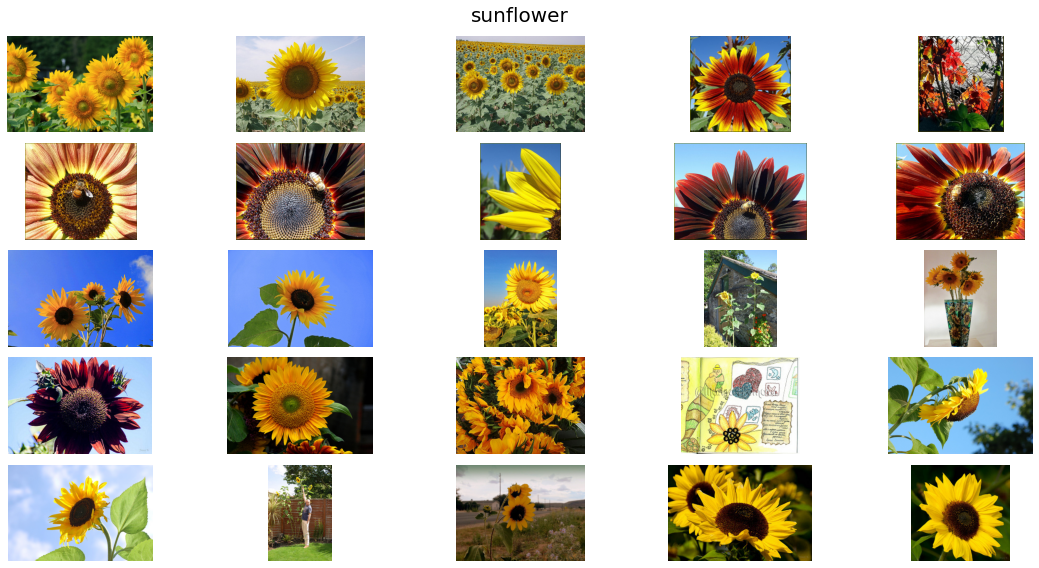

4 tulip


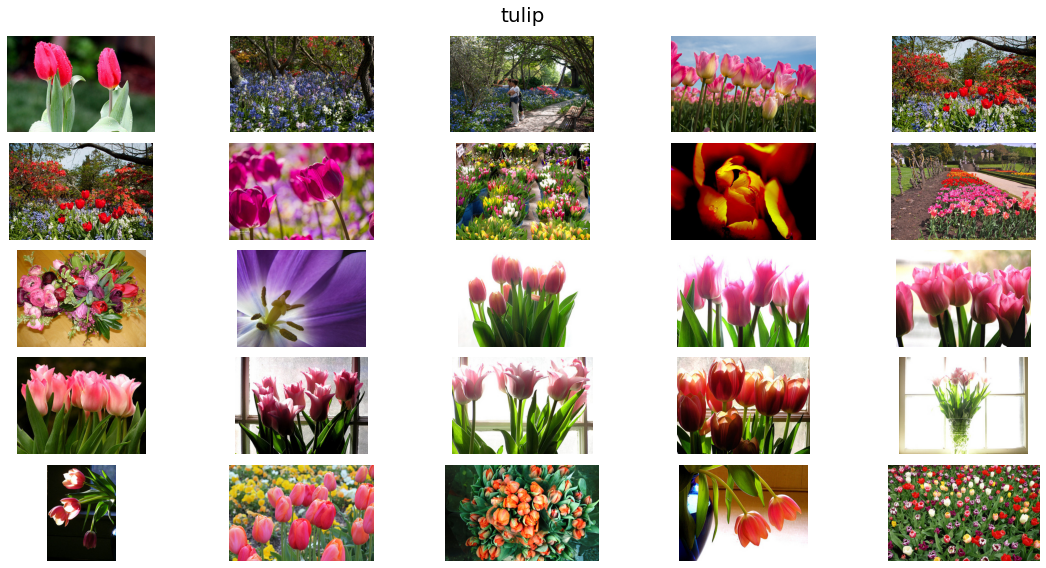

In [10]:
for i in range(5):
  print(i,labels_names[i])
  display_multiple_img(df[df['class'] == i].filename.values[:25],5,5,labels_names[i])

There are 3 method to split data and evaluate:


1. Hold out
2. K-Fold
3. Leave one out

For learning purpose, i only apply hold out method because it's simple and fast. For this dataset, we should use K-fold method to get better validation.


In [11]:
df_train, df_val = train_test_split(df, test_size = 0.20)
df_val, df_test = train_test_split(df_val, test_size = 0.5)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_val = df_test.reset_index(drop = True)
print('Train size: {}, Val size: {}'.format(df_train.shape[0],df_val.shape[0]))

Train size: 3458, Val size: 433


Prepare dataset

In [12]:
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, df,root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.root_dir, row.filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row["class"]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label)

In [8]:
# credit: https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/#4-dropout-as-regularization
# since we need to specify in and out dimensions for linear layers in pytorch.
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [128]
d.append(caloutdim(d[-1], 5))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5))
d.append(caloutdim(d[-1], 2, 2))
print(d)

[128, 124, 62, 58, 29, 25, 12]


## CNN

In [13]:
# image size 64*64
class FlowerNetL1(nn.Module):
    def __init__(self,dropout=0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16*13*13,120),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(120,5)
            )
    def forward(self, x):
        x = self.model(x)
        return x
# image size 128x128
class FlowerNetL2(nn.Module):
    def __init__(self,dropout=0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(32*12*12,120),
            nn.Dropout(p=dropout),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(84,5)
            )
    def forward(self, x):
        x = self.model(x)
        return x

In [52]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class FlowerClassifer:
    def __init__(self,net, batch_size=128, max_epoch=5, lr=1e-4,optimizer=None):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = net.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        if optimizer == None:
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer
        # self.loss_ = []
        # self.test_error = []
        # self.test_accuracy = []
      
        
    def fit(self, trainset, testset, verbose=True, val_one_batch=True):
        trainloader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        test_size = len(testset)
        test_batch_size = 4
        if val_one_batch:
          test_batch_size = test_size
        testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.to(self.device)
         # print(self.model)
        total_step = len(trainloader)
        for epoch in range(self.max_epoch):
            self.model.train()
            training_accuracy=0
            bar = tqdm(trainloader)
            for (images, labels) in bar:
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # Checking accuracy
                preds = outputs.data.max(dim = 1, keepdim = True)[1]
                training_accuracy += preds.eq(labels.data.view_as(preds)).cpu().sum()
                
                
            training_accuracy = training_accuracy/len(trainloader.dataset) * 100
            val_accuracy = self.eval(testloader)
            print ('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}, Validation Accuracy: {:.2f}' 
                   .format(epoch+1, self.max_epoch, loss.item(), training_accuracy,val_accuracy))
        return self
        
    def eval(self,test_loader):
        # Test the model
        self.model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return correct / total *100
        
    def get_accuracy(self,loader):
      correct = 0
      total = 0
      with torch.no_grad():
        for (inputs, labels) in loader:
            inputs = inputs.to(self.device)
            outputs = self.model(inputs).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
      return correct / total

    def predict(self, x):
        model = self.model.eval()
        outputs = model(x).cpu()
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

    def save_model(self,path):
        torch.save(clf.model.state_dict(),path)

    def load_model(self,path):
        if os.path.isfile(path):
          model.load_state_dict(torch.load(path))

In [15]:
def get_simple_transform(img_size):
    return A.Compose(
        [   
            A.Resize(img_size,img_size,always_apply=True),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ]
    )

### Base model

In [17]:
transform = get_simple_transform(64)
dataset_train = FlowerDataset(df_train,DATA_DIR,transform = transform)
dataset_val = FlowerDataset(df_val,DATA_DIR,transform = transform)
net = FlowerNetL1()
clf = FlowerClassifer(net,batch_size=512,max_epoch=50)
clf.fit(dataset_train,dataset_val)


Epoch [1/50], Loss: 1.4757, Training Accuracy: 30.02, Validation Accuracy: 39.72



Epoch [2/50], Loss: 1.2946, Training Accuracy: 44.74, Validation Accuracy: 46.88



Epoch [3/50], Loss: 1.2060, Training Accuracy: 49.13, Validation Accuracy: 51.96



Epoch [4/50], Loss: 1.1762, Training Accuracy: 52.11, Validation Accuracy: 51.50



Epoch [5/50], Loss: 1.2289, Training Accuracy: 54.86, Validation Accuracy: 52.89



Epoch [6/50], Loss: 1.0522, Training Accuracy: 56.13, Validation Accuracy: 54.50



Epoch [7/50], Loss: 1.1200, Training Accuracy: 57.81, Validation Accuracy: 54.27



Epoch [8/50], Loss: 1.0588, Training Accuracy: 58.76, Validation Accuracy: 56.81



Epoch [9/50], Loss: 1.0154, Training Accuracy: 60.82, Validation Accuracy: 56.58



Epoch [10/50], Loss: 0.9979, Training Accuracy: 60.90, Validation Accuracy: 55.66



Epoch [11/50], Loss: 1.0276, Training Accuracy: 62.75, Validation Accuracy: 58.89



Epoch [12/50], Loss: 1.0250, Training Accuracy: 62.90, Validation Accuracy: 58.43



Epoch [13/50], Loss: 0.9698, Training Accuracy: 63.88, Validation Accuracy: 58.89



Epoch [14/50], Loss: 0.9561, Training Accuracy: 64.78, Validation Accuracy: 59.58



Epoch [15/50], Loss: 0.9514, Training Accuracy: 65.56, Validation Accuracy: 59.35



Epoch [16/50], Loss: 0.9483, Training Accuracy: 65.91, Validation Accuracy: 60.28



Epoch [17/50], Loss: 0.8898, Training Accuracy: 66.69, Validation Accuracy: 59.58



Epoch [18/50], Loss: 0.8393, Training Accuracy: 67.50, Validation Accuracy: 58.89



Epoch [19/50], Loss: 0.8682, Training Accuracy: 68.28, Validation Accuracy: 61.43



Epoch [20/50], Loss: 0.8766, Training Accuracy: 68.77, Validation Accuracy: 60.05



Epoch [21/50], Loss: 0.8695, Training Accuracy: 69.09, Validation Accuracy: 59.35



Epoch [22/50], Loss: 0.8350, Training Accuracy: 69.35, Validation Accuracy: 62.82



Epoch [23/50], Loss: 0.7996, Training Accuracy: 70.27, Validation Accuracy: 62.12



Epoch [24/50], Loss: 0.8368, Training Accuracy: 71.31, Validation Accuracy: 60.97



Epoch [25/50], Loss: 0.8094, Training Accuracy: 71.78, Validation Accuracy: 61.43



Epoch [26/50], Loss: 0.7279, Training Accuracy: 72.35, Validation Accuracy: 61.89



Epoch [27/50], Loss: 0.7773, Training Accuracy: 72.59, Validation Accuracy: 61.66



Epoch [28/50], Loss: 0.7993, Training Accuracy: 73.19, Validation Accuracy: 61.89



Epoch [29/50], Loss: 0.7277, Training Accuracy: 73.97, Validation Accuracy: 62.82



Epoch [30/50], Loss: 0.7755, Training Accuracy: 74.73, Validation Accuracy: 61.20



Epoch [31/50], Loss: 0.6847, Training Accuracy: 75.45, Validation Accuracy: 62.59



Epoch [32/50], Loss: 0.7526, Training Accuracy: 75.94, Validation Accuracy: 61.43



Epoch [33/50], Loss: 0.7676, Training Accuracy: 76.72, Validation Accuracy: 63.74



Epoch [34/50], Loss: 0.6955, Training Accuracy: 77.04, Validation Accuracy: 63.97



Epoch [35/50], Loss: 0.6309, Training Accuracy: 77.53, Validation Accuracy: 60.28



Epoch [36/50], Loss: 0.6744, Training Accuracy: 78.28, Validation Accuracy: 60.05



Epoch [37/50], Loss: 0.6784, Training Accuracy: 78.02, Validation Accuracy: 63.05



Epoch [38/50], Loss: 0.6109, Training Accuracy: 79.06, Validation Accuracy: 63.74



Epoch [39/50], Loss: 0.6963, Training Accuracy: 79.50, Validation Accuracy: 63.51



Epoch [40/50], Loss: 0.6503, Training Accuracy: 81.00, Validation Accuracy: 62.59



Epoch [41/50], Loss: 0.6121, Training Accuracy: 79.79, Validation Accuracy: 62.82



Epoch [42/50], Loss: 0.5879, Training Accuracy: 81.17, Validation Accuracy: 62.12



Epoch [43/50], Loss: 0.6214, Training Accuracy: 81.23, Validation Accuracy: 63.28



Epoch [44/50], Loss: 0.5560, Training Accuracy: 82.82, Validation Accuracy: 62.36



Epoch [45/50], Loss: 0.6160, Training Accuracy: 82.74, Validation Accuracy: 63.28



Epoch [46/50], Loss: 0.5841, Training Accuracy: 83.49, Validation Accuracy: 64.67



Epoch [47/50], Loss: 0.5356, Training Accuracy: 83.43, Validation Accuracy: 63.51



Epoch [48/50], Loss: 0.5099, Training Accuracy: 83.81, Validation Accuracy: 64.67



Epoch [49/50], Loss: 0.5684, Training Accuracy: 83.81, Validation Accuracy: 60.51



Epoch [50/50], Loss: 0.5505, Training Accuracy: 84.64, Validation Accuracy: 63.05


In [18]:
results = {}
dataset_test = FlowerDataset(df_test,DATA_DIR,transform = transform)
test_loader = DataLoader(dataset_test,batch_size=4)
test_acc = clf.eval(test_loader)
results["base_cnn"] = test_acc

In [20]:
def test(clf,dataset):
  X_test,y_test = iter(DataLoader(dataset,shuffle=False,batch_size=len(dataset))).next()
  y_pred = clf.predict(X_test.cuda()).cpu().detach().numpy()
  print('Test accuracy:', accuracy_score(y_test,y_pred))
  mat=confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mat,figsize=(9,9),colorbar=True)

**Base model is underfit -> More complex model**

### Base Model V2 ( +1 conv layer, +1 linear layer)

In [21]:
transform = get_simple_transform(128)
dataset_train = FlowerDataset(df_train,DATA_DIR,transform = transform)
dataset_val = FlowerDataset(df_val,DATA_DIR,transform = transform)
net = FlowerNetL2()
clf = FlowerClassifer(net,batch_size=1024,max_epoch=50)
clf.fit(dataset_train,dataset_val)


Epoch [1/50], Loss: 1.5217, Training Accuracy: 25.91, Validation Accuracy: 18.71



Epoch [2/50], Loss: 1.4450, Training Accuracy: 39.79, Validation Accuracy: 35.10



Epoch [3/50], Loss: 1.3515, Training Accuracy: 43.58, Validation Accuracy: 34.41



Epoch [4/50], Loss: 1.2702, Training Accuracy: 46.30, Validation Accuracy: 34.18



Epoch [5/50], Loss: 1.2533, Training Accuracy: 50.06, Validation Accuracy: 38.80



Epoch [6/50], Loss: 1.1733, Training Accuracy: 52.75, Validation Accuracy: 42.03



Epoch [7/50], Loss: 1.1657, Training Accuracy: 54.60, Validation Accuracy: 49.88



Epoch [8/50], Loss: 1.1419, Training Accuracy: 55.73, Validation Accuracy: 50.81



Epoch [9/50], Loss: 1.0748, Training Accuracy: 56.97, Validation Accuracy: 56.12



Epoch [10/50], Loss: 1.0695, Training Accuracy: 58.15, Validation Accuracy: 57.04



Epoch [11/50], Loss: 1.0027, Training Accuracy: 59.28, Validation Accuracy: 58.20



Epoch [12/50], Loss: 1.0376, Training Accuracy: 59.95, Validation Accuracy: 59.12



Epoch [13/50], Loss: 1.0296, Training Accuracy: 61.10, Validation Accuracy: 60.05



Epoch [14/50], Loss: 1.0280, Training Accuracy: 61.65, Validation Accuracy: 59.58



Epoch [15/50], Loss: 0.9431, Training Accuracy: 62.87, Validation Accuracy: 61.20



Epoch [16/50], Loss: 0.9254, Training Accuracy: 63.39, Validation Accuracy: 60.51



Epoch [17/50], Loss: 0.9518, Training Accuracy: 64.89, Validation Accuracy: 62.36



Epoch [18/50], Loss: 0.8924, Training Accuracy: 65.30, Validation Accuracy: 61.89



Epoch [19/50], Loss: 0.8835, Training Accuracy: 65.67, Validation Accuracy: 62.36



Epoch [20/50], Loss: 0.8548, Training Accuracy: 67.03, Validation Accuracy: 63.05



Epoch [21/50], Loss: 0.8693, Training Accuracy: 67.58, Validation Accuracy: 63.97



Epoch [22/50], Loss: 0.8302, Training Accuracy: 67.99, Validation Accuracy: 64.67



Epoch [23/50], Loss: 0.8564, Training Accuracy: 68.65, Validation Accuracy: 63.97



Epoch [24/50], Loss: 0.8474, Training Accuracy: 69.55, Validation Accuracy: 64.20



Epoch [25/50], Loss: 0.7992, Training Accuracy: 69.92, Validation Accuracy: 64.43



Epoch [26/50], Loss: 0.7838, Training Accuracy: 70.97, Validation Accuracy: 63.97



Epoch [27/50], Loss: 0.8257, Training Accuracy: 71.20, Validation Accuracy: 64.67



Epoch [28/50], Loss: 0.7951, Training Accuracy: 72.09, Validation Accuracy: 65.13



Epoch [29/50], Loss: 0.7313, Training Accuracy: 72.93, Validation Accuracy: 63.05



Epoch [30/50], Loss: 0.7451, Training Accuracy: 72.15, Validation Accuracy: 64.90



Epoch [31/50], Loss: 0.7310, Training Accuracy: 73.83, Validation Accuracy: 63.51



Epoch [32/50], Loss: 0.7034, Training Accuracy: 74.03, Validation Accuracy: 65.59



Epoch [33/50], Loss: 0.7102, Training Accuracy: 74.90, Validation Accuracy: 66.05



Epoch [34/50], Loss: 0.7265, Training Accuracy: 75.77, Validation Accuracy: 65.36



Epoch [35/50], Loss: 0.6812, Training Accuracy: 76.26, Validation Accuracy: 65.59



Epoch [36/50], Loss: 0.6898, Training Accuracy: 76.32, Validation Accuracy: 66.51



Epoch [37/50], Loss: 0.6635, Training Accuracy: 78.08, Validation Accuracy: 66.97



Epoch [38/50], Loss: 0.6609, Training Accuracy: 78.20, Validation Accuracy: 63.97



Epoch [39/50], Loss: 0.6267, Training Accuracy: 78.80, Validation Accuracy: 65.59



Epoch [40/50], Loss: 0.6017, Training Accuracy: 78.74, Validation Accuracy: 65.59



Epoch [41/50], Loss: 0.6008, Training Accuracy: 79.90, Validation Accuracy: 67.21



Epoch [42/50], Loss: 0.6062, Training Accuracy: 80.13, Validation Accuracy: 66.05



Epoch [43/50], Loss: 0.5595, Training Accuracy: 79.64, Validation Accuracy: 66.74



Epoch [44/50], Loss: 0.5667, Training Accuracy: 81.03, Validation Accuracy: 66.51



Epoch [45/50], Loss: 0.5549, Training Accuracy: 80.62, Validation Accuracy: 67.67



Epoch [46/50], Loss: 0.5305, Training Accuracy: 82.50, Validation Accuracy: 65.36



Epoch [47/50], Loss: 0.5156, Training Accuracy: 81.55, Validation Accuracy: 64.67



Epoch [48/50], Loss: 0.5311, Training Accuracy: 83.11, Validation Accuracy: 66.28



Epoch [49/50], Loss: 0.5289, Training Accuracy: 83.83, Validation Accuracy: 68.59



Epoch [50/50], Loss: 0.4905, Training Accuracy: 84.82, Validation Accuracy: 68.36


In [23]:
dataset_test = FlowerDataset(df_test,DATA_DIR,transform = get_simple_transform(128))
test_loader = DataLoader(dataset_test,batch_size=4)
test_acc = clf.eval(test_loader)
results["base_cnn_v2"] = test_acc

Test accuracy: 0.6581986143187067


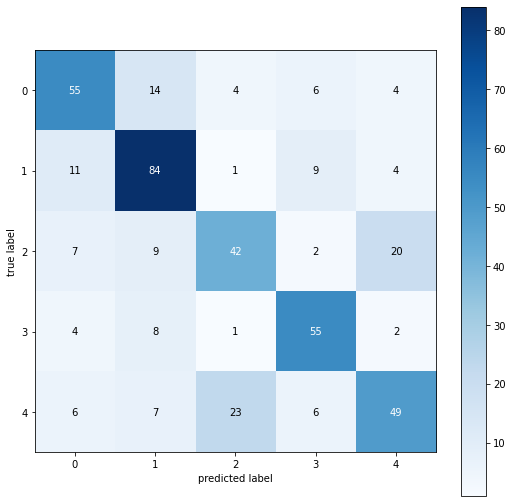

In [47]:
test(clf,dataset_val)



*   Model is overfiting
*   Model has many wrong predictions between class 2(rose) and 4(tulip)



Deal with overfitting:
* Add more data (data augmentation)
* Add regularization

#### Data Augmetation

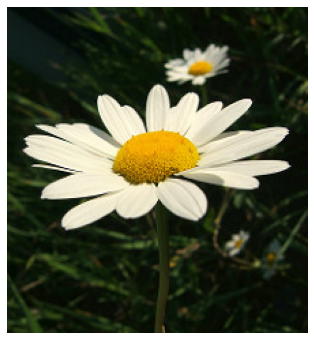

In [34]:
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)

image = cv2.imread(DATA_DIR + df_train.filename.iloc[96])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)


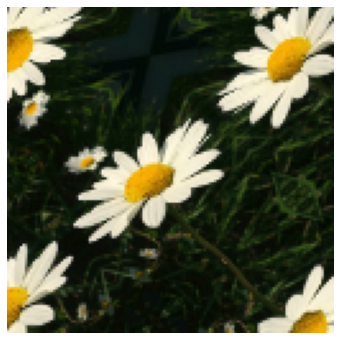

In [39]:
train_transform = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            A.Resize(128,128,always_apply=True),
            #A.GaussNoise(p=0.1),
            A.MedianBlur(blur_limit=3, p=0.1),  
            A.HorizontalFlip(p=0.5),
            A.MedianBlur(blur_limit=3, p=0.1),
            #A.Rotate(limit=120, p=0.8),
            A.RandomBrightness(limit=(0.09, 0.6), p=0.2)
        
])
augmented_image = train_transform(image=image)['image']
visualize(augmented_image)

In [47]:

def get_train_transform(img_size):
  return  A.Compose([
            A.ShiftScaleRotate(),
            A.Resize(img_size,img_size,always_apply=True),
            #A.GaussNoise(p=0.1),
            A.MedianBlur(blur_limit=3, p=0.1),  
            A.HorizontalFlip(p=0.5),
            A.MedianBlur(blur_limit=3, p=0.1),
            #A.Rotate(limit=120, p=0.8),
            #A.RandomBrightness(limit=(0.09, 0.6), p=0.2),
            A.Normalize(),
            ToTensorV2(p=1.0),
        
])


## Regularization

In [48]:
net = FlowerNetL2(dropout=0.2)
net

FlowerNetL2(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4608, out_features=120, bias=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=120, out_features=84, bias=True)
    (16): ReL

In [57]:
dataset_train = FlowerDataset(df_train,DATA_DIR,transform = get_train_transform(128))
dataset_val = FlowerDataset(df_val,DATA_DIR,transform = get_simple_transform(128))
clf = FlowerClassifer(net,batch_size=1024,max_epoch=50)
clf.fit(dataset_train,dataset_val)


Epoch [1/50], Loss: 1.5431, Training Accuracy: 25.33, Validation Accuracy: 27.71



Epoch [2/50], Loss: 1.4322, Training Accuracy: 36.26, Validation Accuracy: 41.57



Epoch [3/50], Loss: 1.3563, Training Accuracy: 42.68, Validation Accuracy: 43.65



Epoch [4/50], Loss: 1.2530, Training Accuracy: 45.08, Validation Accuracy: 44.57



Epoch [5/50], Loss: 1.2951, Training Accuracy: 47.57, Validation Accuracy: 51.04



Epoch [6/50], Loss: 1.2755, Training Accuracy: 49.77, Validation Accuracy: 51.73



Epoch [7/50], Loss: 1.2118, Training Accuracy: 49.22, Validation Accuracy: 51.50



Epoch [8/50], Loss: 1.1534, Training Accuracy: 50.61, Validation Accuracy: 53.35



Epoch [9/50], Loss: 1.1118, Training Accuracy: 53.90, Validation Accuracy: 54.50



Epoch [10/50], Loss: 1.1228, Training Accuracy: 53.59, Validation Accuracy: 53.58



Epoch [11/50], Loss: 1.0600, Training Accuracy: 53.76, Validation Accuracy: 56.35



Epoch [12/50], Loss: 1.1023, Training Accuracy: 54.83, Validation Accuracy: 57.04



Epoch [13/50], Loss: 1.1123, Training Accuracy: 55.93, Validation Accuracy: 58.43



Epoch [14/50], Loss: 1.0744, Training Accuracy: 56.22, Validation Accuracy: 59.58



Epoch [15/50], Loss: 1.0719, Training Accuracy: 55.99, Validation Accuracy: 59.12



Epoch [16/50], Loss: 1.0389, Training Accuracy: 56.94, Validation Accuracy: 60.74



Epoch [17/50], Loss: 0.9956, Training Accuracy: 58.01, Validation Accuracy: 60.97



Epoch [18/50], Loss: 1.0435, Training Accuracy: 58.59, Validation Accuracy: 60.05



Epoch [19/50], Loss: 1.0244, Training Accuracy: 58.01, Validation Accuracy: 62.12



Epoch [20/50], Loss: 0.9917, Training Accuracy: 58.50, Validation Accuracy: 62.82



Epoch [21/50], Loss: 0.9615, Training Accuracy: 59.25, Validation Accuracy: 61.66



Epoch [22/50], Loss: 0.9750, Training Accuracy: 60.06, Validation Accuracy: 64.20



Epoch [23/50], Loss: 1.0285, Training Accuracy: 60.09, Validation Accuracy: 64.67



Epoch [24/50], Loss: 1.0098, Training Accuracy: 60.09, Validation Accuracy: 63.05



Epoch [25/50], Loss: 1.0067, Training Accuracy: 61.02, Validation Accuracy: 64.67



Epoch [26/50], Loss: 0.9896, Training Accuracy: 61.13, Validation Accuracy: 63.97



Epoch [27/50], Loss: 0.8889, Training Accuracy: 62.32, Validation Accuracy: 65.36



Epoch [28/50], Loss: 0.9762, Training Accuracy: 62.06, Validation Accuracy: 66.05



Epoch [29/50], Loss: 0.9709, Training Accuracy: 62.09, Validation Accuracy: 64.90



Epoch [30/50], Loss: 0.9852, Training Accuracy: 62.20, Validation Accuracy: 65.82



Epoch [31/50], Loss: 0.9943, Training Accuracy: 62.87, Validation Accuracy: 65.13



Epoch [32/50], Loss: 0.9369, Training Accuracy: 63.71, Validation Accuracy: 64.20



Epoch [33/50], Loss: 0.8885, Training Accuracy: 63.56, Validation Accuracy: 65.59



Epoch [34/50], Loss: 0.8998, Training Accuracy: 64.57, Validation Accuracy: 67.21



Epoch [35/50], Loss: 1.0143, Training Accuracy: 63.04, Validation Accuracy: 67.67



Epoch [36/50], Loss: 0.8654, Training Accuracy: 64.81, Validation Accuracy: 67.44



Epoch [37/50], Loss: 0.8905, Training Accuracy: 64.49, Validation Accuracy: 67.67



Epoch [38/50], Loss: 0.9165, Training Accuracy: 64.69, Validation Accuracy: 66.51



Epoch [39/50], Loss: 0.8681, Training Accuracy: 65.44, Validation Accuracy: 66.74



Epoch [40/50], Loss: 0.8918, Training Accuracy: 65.76, Validation Accuracy: 69.28



Epoch [41/50], Loss: 0.9268, Training Accuracy: 66.57, Validation Accuracy: 67.44



Epoch [42/50], Loss: 0.8435, Training Accuracy: 66.57, Validation Accuracy: 67.90



Epoch [43/50], Loss: 0.7739, Training Accuracy: 66.63, Validation Accuracy: 66.74



Epoch [44/50], Loss: 0.7953, Training Accuracy: 67.87, Validation Accuracy: 68.36



Epoch [45/50], Loss: 0.7939, Training Accuracy: 67.96, Validation Accuracy: 68.59



Epoch [46/50], Loss: 0.8093, Training Accuracy: 67.61, Validation Accuracy: 67.90



Epoch [47/50], Loss: 0.8528, Training Accuracy: 66.86, Validation Accuracy: 68.59



Epoch [48/50], Loss: 0.8605, Training Accuracy: 68.31, Validation Accuracy: 69.52



Epoch [49/50], Loss: 0.7910, Training Accuracy: 68.02, Validation Accuracy: 67.90



Epoch [50/50], Loss: 0.8416, Training Accuracy: 69.00, Validation Accuracy: 68.13


Test accuracy: 0.6812933025404158


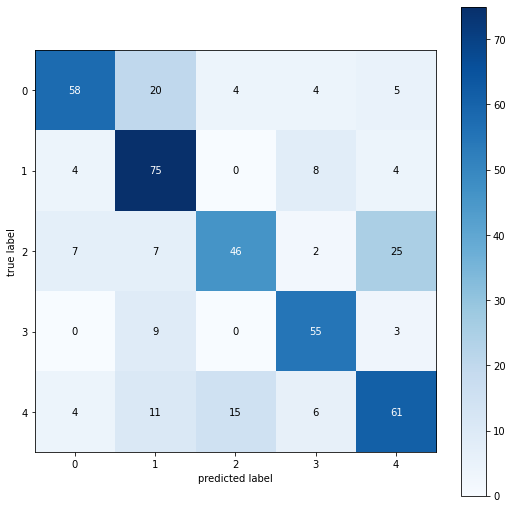

In [58]:
test(clf,dataset_val)

In [59]:
dataset_test = FlowerDataset(df_test,DATA_DIR,transform = get_simple_transform(128))
test_loader = DataLoader(dataset_test,batch_size=4)
test_acc = clf.eval(test_loader)
results["base_cnn_v2_aug_dropout"] = test_acc

## Transfer learning

Instead of training the big neural network from scratch. I finetune the pre-trained model just by changing the classifier


In [70]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True,dropout_rate=0):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    model_ft = timm.create_model(model_name,pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    if dropout_rate == 0:
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    else:
        model_ft.fc = nn.Sequential(
            nn.Linear(512,120),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(120,5)
        )
    input_size = 224

    return model_ft, input_size

In [81]:
# credit: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
feature_extract = True
model_ft,im_size = initialize_model('resnet18',5,feature_extract)
model_ft = model_ft.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 fc.weight
	 fc.bias


In [82]:
dataset_train = FlowerDataset(df_train,DATA_DIR,transform = get_train_transform(im_size))
dataset_val = FlowerDataset(df_val,DATA_DIR,transform = get_simple_transform(im_size))
clf = FlowerClassifer(model_ft,batch_size=16,max_epoch=15,optimizer=optimizer_ft)
clf.fit(dataset_train,dataset_val)


Epoch [1/15], Loss: 2.7971, Training Accuracy: 69.81, Validation Accuracy: 86.14



Epoch [2/15], Loss: 0.2058, Training Accuracy: 81.38, Validation Accuracy: 88.91



Epoch [3/15], Loss: 1.8483, Training Accuracy: 83.75, Validation Accuracy: 90.07



Epoch [4/15], Loss: 0.3909, Training Accuracy: 84.04, Validation Accuracy: 89.38



Epoch [5/15], Loss: 0.7507, Training Accuracy: 84.30, Validation Accuracy: 87.99



Epoch [6/15], Loss: 2.6610, Training Accuracy: 85.19, Validation Accuracy: 89.15



Epoch [7/15], Loss: 0.5610, Training Accuracy: 85.14, Validation Accuracy: 89.61



Epoch [8/15], Loss: 0.4934, Training Accuracy: 85.71, Validation Accuracy: 90.07



Epoch [9/15], Loss: 2.4162, Training Accuracy: 85.89, Validation Accuracy: 88.68



Epoch [10/15], Loss: 0.1317, Training Accuracy: 85.02, Validation Accuracy: 89.15



Epoch [11/15], Loss: 0.2895, Training Accuracy: 86.35, Validation Accuracy: 89.61



Epoch [12/15], Loss: 1.6088, Training Accuracy: 87.19, Validation Accuracy: 89.61



Epoch [13/15], Loss: 0.7890, Training Accuracy: 86.44, Validation Accuracy: 89.15



Epoch [14/15], Loss: 0.9083, Training Accuracy: 86.21, Validation Accuracy: 90.53



Epoch [15/15], Loss: 1.0081, Training Accuracy: 86.35, Validation Accuracy: 90.07


Test accuracy: 0.9006928406466512


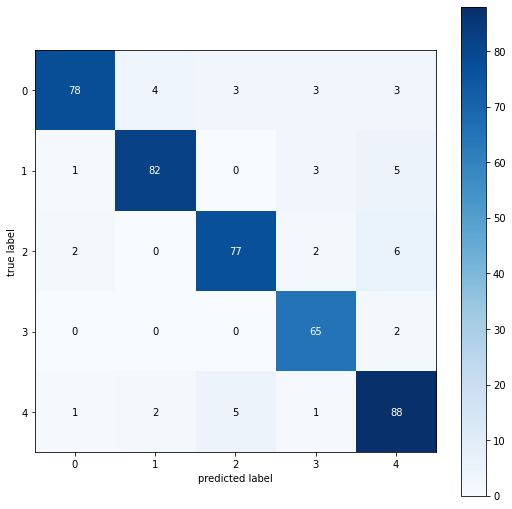

In [83]:
test(clf,dataset_val)

In [84]:
dataset_test = FlowerDataset(df_test,DATA_DIR,transform = get_simple_transform(128))
test_loader = DataLoader(dataset_test,batch_size=4)
test_acc = clf.eval(test_loader)
results["resnet_finetuned_aug"] = test_acc

In [89]:
torch.save(clf.model.state_dict(),"resnet_finetuned_aug.pt")

#### Try combine with Dropout

In [86]:
# credit: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
feature_extract = True
model_ft,im_size = initialize_model('resnet18',5,feature_extract,dropout_rate=0.2)
model_ft = model_ft.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.3.weight
	 fc.3.bias


In [91]:
dataset_train = FlowerDataset(df_train,DATA_DIR,transform = get_train_transform(im_size))
dataset_val = FlowerDataset(df_val,DATA_DIR,transform = get_simple_transform(im_size))
clf = FlowerClassifer(model_ft,batch_size=16,max_epoch=15,optimizer=optimizer_ft)
clf.fit(dataset_train,dataset_val)


Epoch [1/15], Loss: 0.9480, Training Accuracy: 61.74, Validation Accuracy: 83.83



Epoch [2/15], Loss: 1.0430, Training Accuracy: 76.84, Validation Accuracy: 87.76



Epoch [3/15], Loss: 1.3999, Training Accuracy: 80.28, Validation Accuracy: 87.99



Epoch [4/15], Loss: 2.5055, Training Accuracy: 81.81, Validation Accuracy: 90.99



Epoch [5/15], Loss: 1.1916, Training Accuracy: 82.56, Validation Accuracy: 89.15



Epoch [6/15], Loss: 1.6449, Training Accuracy: 83.02, Validation Accuracy: 89.61



Epoch [7/15], Loss: 0.7521, Training Accuracy: 84.07, Validation Accuracy: 89.61



Epoch [8/15], Loss: 0.1442, Training Accuracy: 84.30, Validation Accuracy: 90.07



Epoch [9/15], Loss: 0.7820, Training Accuracy: 85.40, Validation Accuracy: 90.99



Epoch [10/15], Loss: 1.8831, Training Accuracy: 85.45, Validation Accuracy: 89.61



Epoch [11/15], Loss: 1.5145, Training Accuracy: 85.25, Validation Accuracy: 89.38



Epoch [12/15], Loss: 0.7453, Training Accuracy: 85.66, Validation Accuracy: 89.61



Epoch [13/15], Loss: 0.7142, Training Accuracy: 85.54, Validation Accuracy: 90.07



Epoch [14/15], Loss: 1.1937, Training Accuracy: 86.78, Validation Accuracy: 90.53



Epoch [15/15], Loss: 0.5191, Training Accuracy: 87.13, Validation Accuracy: 90.07


Test accuracy: 0.9006928406466512


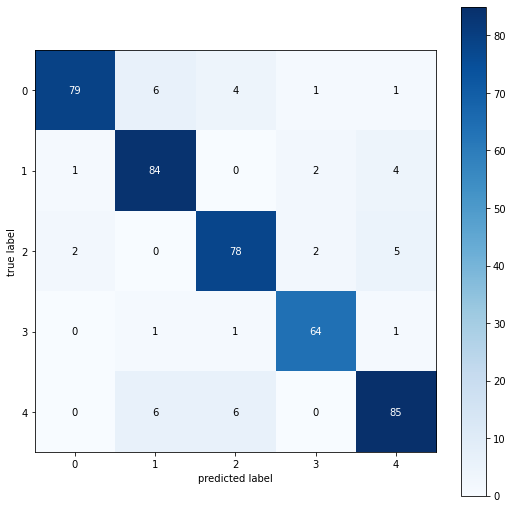

In [92]:
test(clf,dataset_val)

In [123]:
dataset_test = FlowerDataset(df_test,DATA_DIR,transform = get_simple_transform(im_size))
test_loader = DataLoader(dataset_test,batch_size=4)
test_acc = clf.eval(test_loader)
results["resnet_finetuned_aug_dropout"] = test_acc

In [126]:
clf.eval(test_loader)

90.06928406466513

In [110]:
torch.save(clf.model.state_dict(),"resnet_finetuned_aug_dropout.pt")

## Results

In [98]:
results

{'base_cnn': 63.04849884526559,
 'base_cnn_v2': 68.36027713625866,
 'base_cnn_v2_aug_dropout': 68.12933025404158,
 'resnet_finetuned_aug': 84.29561200923787,
 'resnet_finetuned_aug_dropout': 85.21939953810623}

In [109]:
df_results = pd.DataFrame(data=[[x,y] for x,y in results.items()],columns=['Model name','Test accuracy'])
df_results

Model name  Test accuracy
0                      base_cnn      63.048499
1                   base_cnn_v2      68.360277
2       base_cnn_v2_aug_dropout      68.129330
3          resnet_finetuned_aug      84.295612
4  resnet_finetuned_aug_dropout      85.219400

## Test with a real image

This is a tulip


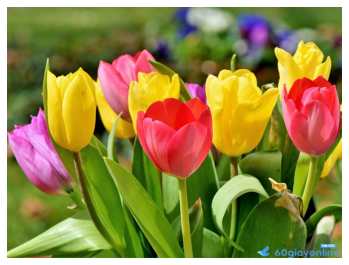

In [147]:
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)

image = cv2.imread('hoa-tulip.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)
transform = get_simple_transform(im_size)
model_ft.eval()
i = torch.unsqueeze(transform(image=image)['image'],0)
outputs = model_ft.cpu()(i)
prob, index = torch.max(outputs.data, 1)
print("This is a", labels_names[index])